In [101]:
import pandas as pd
import glob
pd.options.mode.chained_assignment = None 
import datetime
import seaborn as sns
import datetime

In [85]:


# PATHS

#Den Bosch flow
path = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150/"
path1 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1876_flow/"
path2 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1882_flow/"


#Bokhoven level
path3 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_L0/"
#Bokhoven flow
path4 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_Q0/"


#Haarsteeg level
path5 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_N99/"
#Haarsteeg flow
path6 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_99/"


#Helftheuvelweg level column 003 Helftheuvelweg *.csv
path7 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Helftheuvelweg flow 
path8 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT301_99/"


#Engelerschans level column “004 Engelerschans” *.csv
path9 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Engelerschans flow + Haarsteeg + Bokhoven, therefore substract for only Engeleschans
path10 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT201_99/"


#Maaspoort level Column: “006 Maaspoort” *.csv 
path11 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Maasport flow + Rompert
path12= "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"


#Oude Engelenseweg level Column: “002 Oude Engelenseweg” *.csv
path13 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Oude Engelenseweg flow
path14 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT401_94/"


#De Rompert level Column: “005 de Rompert” *.csv
path15 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#De Rompert flow + Maasport
path16 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"

In [87]:
#Location linkage
path_linkinfo = "../data/waterschap-aa-en-maas_sewage_2019/sewer_model"
path_rain = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries"

#Missing Engelerschans and RWZI Den Bosch linking streets inside the linking document(Someone revisit this please e.g @Roger)
#Another missing thing this time in the rainfall data itself are streets in "Hertogenbosch (Oude Engelenseweg)" and in "Hertogenbosch (Maaspoort)", if you want to
#see, plug "Hertogenbosch (Oude Engelenseweg)" or the other one in station_names to see exactly which streets are not in index
# THIS IS SOMETHING TO REPORT AS MISSING IN OUR DELIVERABLE!!!

station_names = ["Haarsteeg", "Bokhoven", "Hertogenbosch (Helftheuvelweg)", "Hertogenbosch (Rompert)"]
link = pd.read_csv(path_linkinfo+
                   "/20180717_dump riodat rioleringsdeelgebieden_matched_to_rainfall_locations.csv",
                   header = 9)

#Street names by stations
streets = [list(link[link["Naam kern"] == name]["Naam / lokatie"]) for name in station_names]

rain = pd.concat([pd.read_csv(file, header = 2) for file in glob.glob(path_rain+"/*.*")], ignore_index = True)

#All the rain for the streets for the pump stations in order of station_names and the streets per station
#can be found in streets nested list in the same order


all_areas = rain[["Begin", "Eind"] + [i for sl in streets for i in sl]]


In [88]:
all_areas2 = pd.DataFrame()

for i in range(len(station_names)):
    all_areas2[station_names[i]] = rain[streets[i]].sum(1)

all_areas2["Begin"] =  all_areas["Begin"]
all_areas2["End"] = all_areas["Eind"]

In [ ]:
# The sum of the rain at all locations
all_areas2

In [91]:
all_areas2["Begin"] = pd.to_datetime(all_areas2["Begin"])
all_areas2["date"] = all_areas2["Begin"].dt.date

# The sum of the rain at all locations per day
all_areas2_days = all_areas2.groupby('date').sum()

def condition_days(rain_value): #conditions are made based on wikipedia numbers, intensity section
    if rain_value == 0:         #https://en.wikipedia.org/wiki/Rain
        return "No"
    elif 0 < rain_value <= 2.352 :
        return 'light'
    elif 2.352 < rain_value <= 7.2:
        return 'moderate'
    elif 7.2 < rain_value <= 48:
        return 'heavy'
    elif 48 < rain_value:
        return 'Violent'
    else:
        return 'Something went wrong'

def level_of_rain(names_list, df_day):
    for i in names_list:
        df_day["Rain measure " + i] = df_day.apply(lambda x: condition_days(x[i]), axis=1)
    return df_day   

level = level_of_rain(station_names, all_areas2_days)

In [93]:
def condition_days2(day, dictio):
    return dictio[day]

def level_of_rain2(names_list, df_5min, df_day):
    for i in names_list:
        dictio = df_day.to_dict()["Rain measure " + i]
        df_5min["Rain measure " + i] = df_5min.apply(lambda x: condition_days2(x["date"], dictio), axis = 1)
    return df_5min

level2 = level_of_rain2(station_names, all_areas2, all_areas2_days)


In [112]:
level2

,Haarsteeg,Bokhoven,Hertogenbosch (Helftheuvelweg),Hertogenbosch (Rompert),Begin,End,date,Rain measure Haarsteeg,Rain measure Bokhoven,Rain measure Hertogenbosch (Helftheuvelweg),Rain measure Hertogenbosch (Rompert)
0,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:00:00,31-05-2018 22:05:00,2018-05-31,heavy,moderate,Violent,heavy
1,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:05:00,31-05-2018 22:10:00,2018-05-31,heavy,moderate,Violent,heavy
2,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:10:00,31-05-2018 22:15:00,2018-05-31,heavy,moderate,Violent,heavy
3,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:15:00,31-05-2018 22:20:00,2018-05-31,heavy,moderate,Violent,heavy
4,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:20:00,31-05-2018 22:25:00,2018-05-31,heavy,moderate,Violent,heavy
5,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:25:00,31-05-2018 22:30:00,2018-05-31,heavy,moderate,Violent,heavy
6,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:30:00,31-05-2018 22:35:00,2018-05-31,heavy,moderate,Violent,heavy
7,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:35:00,31-05-2018 22:40:00,2018-05-31,heavy,moderate,Violent,heavy
8,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:40:00,31-05-2018 22:45:00,2018-05-31,heavy,moderate,Violent,heavy
9,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:45:00,31-05-2018 22:50:00,2018-05-31,heavy,moderate,Violent,heavy


In [143]:
level2

,Haarsteeg,Bokhoven,Hertogenbosch (Helftheuvelweg),Hertogenbosch (Rompert),Begin,End,date,Rain measure Haarsteeg,Rain measure Bokhoven,Rain measure Hertogenbosch (Helftheuvelweg),Rain measure Hertogenbosch (Rompert)
0,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:00:00,31-05-2018 22:05:00,2018-05-31,heavy,moderate,Violent,heavy
1,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:05:00,31-05-2018 22:10:00,2018-05-31,heavy,moderate,Violent,heavy
2,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:10:00,31-05-2018 22:15:00,2018-05-31,heavy,moderate,Violent,heavy
3,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:15:00,31-05-2018 22:20:00,2018-05-31,heavy,moderate,Violent,heavy
4,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:20:00,31-05-2018 22:25:00,2018-05-31,heavy,moderate,Violent,heavy
5,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:25:00,31-05-2018 22:30:00,2018-05-31,heavy,moderate,Violent,heavy
6,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:30:00,31-05-2018 22:35:00,2018-05-31,heavy,moderate,Violent,heavy
7,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:35:00,31-05-2018 22:40:00,2018-05-31,heavy,moderate,Violent,heavy
8,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:40:00,31-05-2018 22:45:00,2018-05-31,heavy,moderate,Violent,heavy
9,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:45:00,31-05-2018 22:50:00,2018-05-31,heavy,moderate,Violent,heavy


In [136]:
path6 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_99/"
df = pd.concat([pd.read_csv(file) for file in glob.glob(path6+"/*.*")], ignore_index = True)
df["datumBeginMeting"] = pd.to_datetime(df["datumBeginMeting"])
#df.set_index("datumBeginMeting").resample("5T").mean().shape, level2[level2["Begin"] >= min(df["datumBeginMeting"])].shape

((172800, 5), (128101, 11))

In [251]:
rain = level2[(level2["Begin"] >= min(df["datumBeginMeting"])) &
                 (level2["Begin"] <= max(df["datumBeginMeting"]))]


In [250]:
flow = df[(df["datumBeginMeting"] >= min(level2["Begin"])) &
           (df["datumBeginMeting"] <= max(leveltop["Begin"]))]


In [252]:
#len(dftop.set_index("datumBeginMeting").resample("5T").sum())
rain

,Haarsteeg,Bokhoven,Hertogenbosch (Helftheuvelweg),Hertogenbosch (Rompert),Begin,End,date,Rain measure Haarsteeg,Rain measure Bokhoven,Rain measure Hertogenbosch (Helftheuvelweg),Rain measure Hertogenbosch (Rompert)
0,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:00:00,31-05-2018 22:05:00,2018-05-31,heavy,moderate,Violent,heavy
1,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:05:00,31-05-2018 22:10:00,2018-05-31,heavy,moderate,Violent,heavy
2,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:10:00,31-05-2018 22:15:00,2018-05-31,heavy,moderate,Violent,heavy
3,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:15:00,31-05-2018 22:20:00,2018-05-31,heavy,moderate,Violent,heavy
4,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:20:00,31-05-2018 22:25:00,2018-05-31,heavy,moderate,Violent,heavy
5,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:25:00,31-05-2018 22:30:00,2018-05-31,heavy,moderate,Violent,heavy
6,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:30:00,31-05-2018 22:35:00,2018-05-31,heavy,moderate,Violent,heavy
7,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:35:00,31-05-2018 22:40:00,2018-05-31,heavy,moderate,Violent,heavy
8,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:40:00,31-05-2018 22:45:00,2018-05-31,heavy,moderate,Violent,heavy
9,0.0000,0.0000,0.0000,0.0000,2018-05-31 22:45:00,31-05-2018 22:50:00,2018-05-31,heavy,moderate,Violent,heavy


In [260]:
Haarsteeg = rain[["Haarsteeg", "Begin", "Rain measure Haarsteeg"]]
#Getting dates with no rain
no_rain = set(Haarsteeg[Haarsteeg["Rain measure Haarsteeg"] == "No"]["Begin"].dt.date)
#Filtering on those dates
flow_filtered = flow[flow["datumBeginMeting"].dt.date.isin(no_rain)]

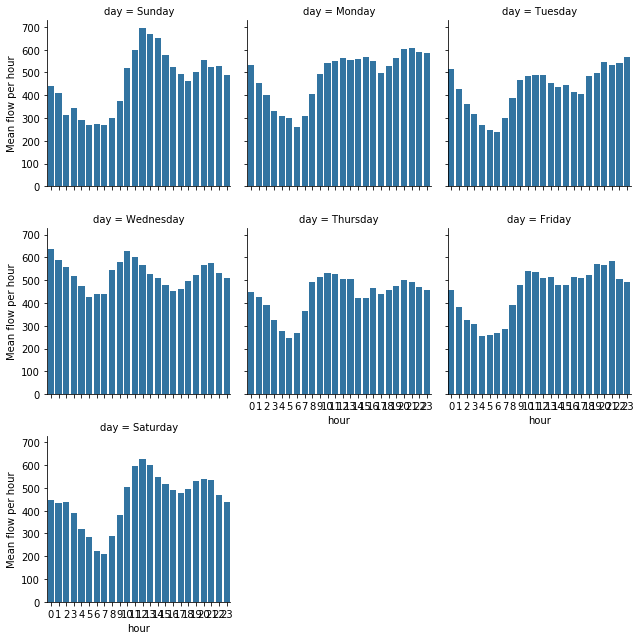

In [265]:
# Need to check if the flow between ""datumBeginMeting" and "datumEindMeting" is the average in that time period or what
# is the interpretation of the data exactly????
flow_filtered["day"] = flow_filtered["datumBeginMeting"].dt.day_name()
flow_filtered["hour"] = flow_filtered["datumBeginMeting"].dt.hour

g = sns.FacetGrid(data = flow_filtered.groupby([
        "day", "hour"
]).hstWaarde.mean().to_frame(name="Mean flow per hour").reset_index(), col="day", col_order=[
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday"
], col_wrap=3)

g.map(sns.barplot, "hour", "Mean flow per hour");